# Теория Машинного Обучения

## 1. Типы алгоритмов

### Основные алгоритмы

**Классификация и регрессия**

In [1]:
import numpy as np
import pandas as pd

from sklearn.datasets import make_classification, make_regression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import f1_score, mean_squared_error, accuracy_score

Классификация

Алгоритм в обоих случаях одинаковый:
 * Создаем искуственные данные
 * Разделяем их на признаки и целевую переменную
 * Разбиваем данные на train и test
 * Обучаем модель и проверяем на подходящей метрике

In [2]:
data = make_classification(n_samples=10000)

In [3]:
X, y = data[0], data[1]

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [5]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
f1_score(y_test, y_pred)

0.9743178170144462

In [6]:
accuracy_score(y_test, y_pred)

0.9744

Регрессия

In [7]:
data = make_regression(n_samples=1000)

In [8]:
X, y = data[0], data[1]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [10]:
reg = RandomForestRegressor(max_depth=5)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

79.87310733827579

Посмотрим на разброс значений нашей целевой переменной и сравним с результатами нашей модели, чтобы понять, насколько сильно предсказания нашей модели меньше или больше разброса в целевой переменной.

In [11]:
np.std(y)

159.24223371566325

Сравним нашу модель с dummy-моделью.  
За dummy-модель возьмем такую модель, котораяя на любой входной пример возвращает среднее значение.

In [12]:
np.sqrt(mean_squared_error(y_test, np.array([np.mean(y_test)] * len(y_test))))

168.81816989371367

**Кластеризация и уменьшение размерности**

Кластеризация

KMeans

Не очень умный алгоритм, который просто смотрит на расстояние между признаками. Ему нужно задавать предполагаемое количество классов – еще один из его недостатков.  
Несмотря на это, в простых случаях он работает и для нахождения оптимального количества классов можно использовать метод локтя.

In [13]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

%matplotlib inline

C:\Users\molde\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\molde\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


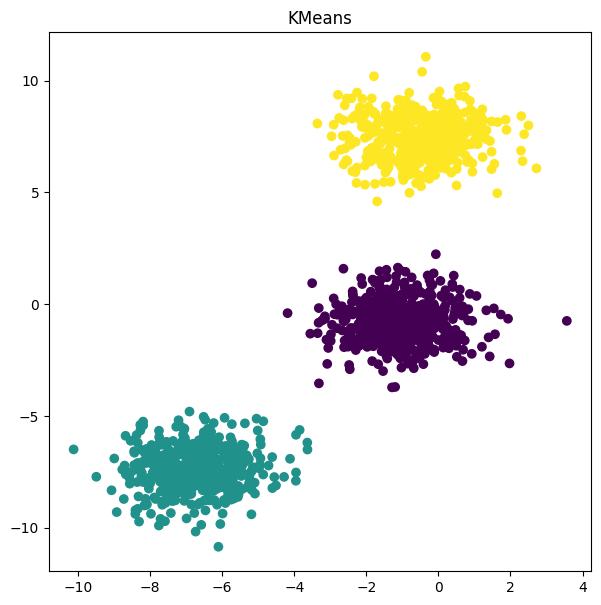

In [14]:
X, _ = make_blobs(n_samples=1500)

y_pred = KMeans(n_clusters=3).fit_predict(X)

plt.figure(figsize=(7, 7))
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.title("KMeans");

DBSCAN

Более сложный алгоритм, который сам умеет подбирать нужное количество классов и определять те точки, которые являются шумом.  
Сложность в том, что он имеет два параметра, от которых все сильно зависит.

In [15]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

In [16]:
centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(n_samples=750, centers=centers, cluster_std=0.4, random_state=0)

X = StandardScaler().fit_transform(X)

У алгоритма DBSCAN два параметра, которые регулируют, как много соседей должно быть вокруг точки, чтобы она присоединилась к их классу.

In [17]:
db = DBSCAN(eps=0.35, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

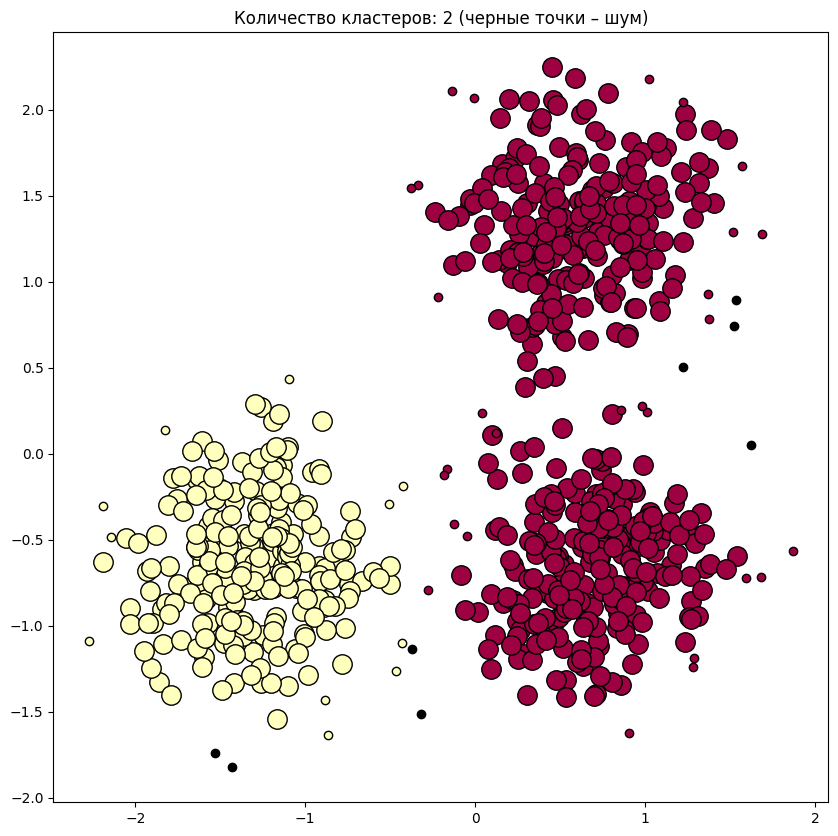

In [18]:
plt.figure(figsize=(10, 10))
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Количество кластеров: %d (черные точки – шум)' % n_clusters_);

Уменьшение размерности

Алгоритмы уменьшения размерности часто нужны в следующих ситуациях:
 * У нас много признаков и мы хотим сократить их количество, чтобы модели лучше обучались
 * У нас много признаков, а мы хотим как-то визуализировать наши признаки и возможно кластеризовать их

In [19]:
import seaborn as sns
from sklearn.datasets import load_digits
from sklearn.manifold import TSNE
import matplotlib.patheffects as PathEffects

In [20]:
digits = load_digits()
X = np.vstack([digits.data[digits.target==i]
               for i in range(10)])
y = np.hstack([digits.target[digits.target==i]
               for i in range(10)])

In [21]:
digits_proj = TSNE().fit_transform(X)

In [22]:
def scatter(x, colors):
    palette = np.array(sns.color_palette("hls", 10))

    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    txts = []
    for i in range(10):
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

AttributeError: module 'numpy' has no attribute 'int'.
`np.int` was a deprecated alias for the builtin `int`. To avoid this error in existing code, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

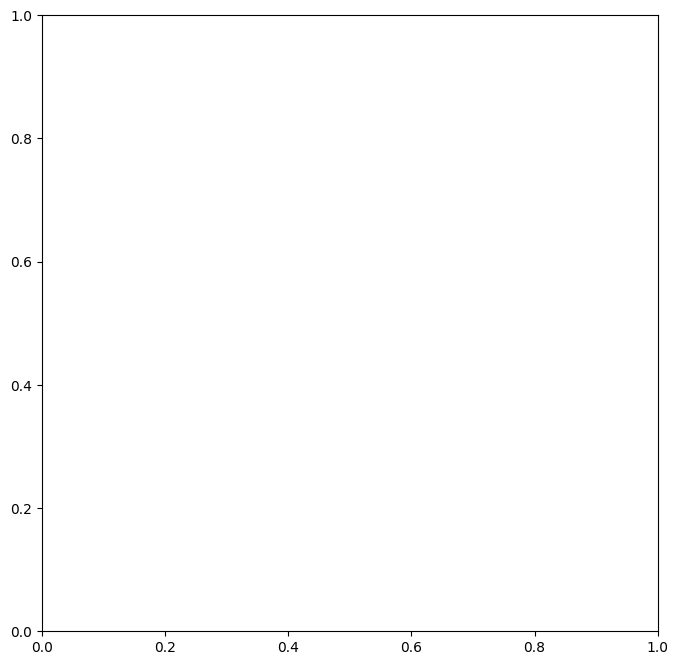

In [23]:
scatter(digits_proj, y);

Интересные примеры: https://colah.github.io/posts/2014-10-Visualizing-MNIST/

### Что еще бывает

* **Языковые модели** - без учителя, “умеют” генерировать следующее слово/букву/часть слова по предыдущим, обычно называют semi-supervised или self-supervised
* **Автоэнкодеры** (автокодировщики, autoencoders) - без учителя, “бутылочное горлышко”, модель, которая сначала сжимает данные в вектор небольшой размерности (латентное представление), а затем восстанавливает их, тоже semi/self-supervised
* **Смесь обучения с учителем и без** – например, тренируется автоэнкодер (на большом количестве данных, без учителя), а потом (или параллельно) дообучается другая модель, использующая латентное представление в качестве входа (с разметкой, на малом количестве данных)
* **Рекомендательные системы**
* **Регрессия и классификация, обученные на исторических данных** - разметка (учитель) возникает в процессе взаимодействия большого количества пользователей с системой (как и в случае рекомендательных систем)
* **Обучение с подкреплением** (Reinforcement Learning)
* И многое другое

## 2. Этапы решения задачи

**1. Определение бизнес-требований**
* Что хочется построить
* Кто пользователь, сколько событий в системе
* Есть ли какие-то жёсткие ограничения

**2. Цель обучения** - какая-то измеримая (SMART) метрика

**3. Выбор архитектуры на высоком уровне**
* Онлайн предсказания или разовый предподсчёт ответов для всех пользователей
* Регулярность пересчёта моделей (разово, раз в N дней, онлайн дообучение)
* Что модель принимает на вход и что выдаёт

**4. Определение типа задачи**
* С учителем или без
* Регрессия/классификация/рекомендательная/и т.п.
* Определение функции потерь


**5. Сигналы, полезные для модели**
* Признаки пользователя
* Признаки объектов системы
* Признаки взаимодействия пользователей с системой
* Из этих сигналов мы получим фичи для модели (они будут зависеть от типа модели)


**6. Процесс сбора данных**
* Исторические данные о взаимодействии пользователей и системы - для этого источника важно описать, как именно происходит сбор, фильтрация, агрегация данных, описать регулярность и последовательность действий, а также форматы данных
* Разметка - описать откуда берутся данные для разметки, кто и как размечает данные
* Обучение на внешних источниках (языковая модель на википедии, например)


**7. Модель**
* Baseline-модель - самый простой подход, который будет работать и относительно которого можно будет измерять качество
* Продвинутый вариант модели, рассматриваются разные варианты и потенциальные улучшения


**8. Оффлайн проверка модели**
* Необходимо один раз в самом начале зафиксировать набор данных, на которых будут тестироваться все модели
* Этот набор должен быть “спрятан” от алгоритма - не должно быть пересечений с тренировочным набором
* Необходима метрика для модели, по которой производится сравнение (это не та метрика, которая является целью обучения; например, целью обучения может быть увеличение количества совершённых покупок, а метрикой для модели - кросс энтропия между предсказанными и фактическими кликами)


**9. Переобучение**
* “Запоминание” тренировочного множества и плохая работа на всех новых данных
* Как понять, что оно есть - расхождение графиков обучения и валидации
* Как бороться с переобучением
  * Увеличение количества тренировочных данных
  * Уменьшение сложности модели (количества признаков, количества параметров модели)
  * Уменьшение количества итераций алгоритма
  * Уменьшение learning rate
  * Регуляризация (ограничение на параметры с помощью дополнительной функции потерь)


**10. Онлайн проверка модели**
* AB-тестирование (малый процент пользователей получает новые результаты, процент можно постепенно увеличивать)
* Нужно выбрать онлайн-метрики для сравнения
* Результаты должны быть статистически значимы
* Не должно быть разницы в структуре тестовых и исходных пользователей


**11. Отладка модели**: что делать, если оффлайн всё хорошо, а онлайн плохо?
* Анализировать структуру тренировочных, тестовых и онлайн данных
* Убедиться в адекватности метрик 
* Проверить, что нет переобучения (тестовые данные попали в тренировочные?)
* Посмотреть, что происходит на конкретных примерах


**12. Инфраструктура**: API, конфигурации, модули и т. п.
* Как тренируется модель?
* Как происходит тестирование?
* Как происходит внедрение модели?
* Производительность, количество машин для вычисления значений
